In [ ]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 12.8MB 220kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 7.5MB/s 


In [ ]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-08 18:12:45--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-08 18:12:45--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e3651dab839988019cfb8fe35.dl.dropboxusercontent.com/cd/0/get/BKSoEDwrL1BoDTBhfqk7DohaXcIQtjG6SKDo6kOPjxL4-hz2XpzNvVEIv7aN8t1aXU-dJMi4kqy97CnSq5NV5WBx_s1h-NRys1S4q3ohsUtCkDoH8S7MpeGSTCuHRSVzZZCZ8MiweW4kkX93opzzpMKT/file?dl=1# [following]
--2021-03-08 18:12:46--  https://uc8e3651dab839988019cfb8fe35.dl.dropboxusercontent.com/cd/0/get/BKSoEDwrL1BoDTBhfqk7DohaXcIQtjG6SKDo6kOPjxL4-hz2XpzNvVEIv7aN8t1a

In [ ]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *
import torch
torch.cuda.set_device(1)

In [2]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [3]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [4]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=8)

In [5]:
from fastai.vision.all import *
import timm
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [6]:
modelo=timm.models.hrnet.hrnet_w64(num_classes=2)

In [7]:
lr=1e-4

## Ranger

In [9]:
opt_func = partial(ranger, beta=0.99, eps=1e-6)

In [9]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=0.14454397559165955)

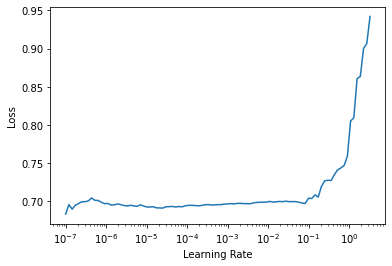

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.695889,0.696687,0.469419,0.457478,0.490566,01:38
1,0.694370,0.697941,0.483180,0.477679,0.672956,01:39


Better model found at epoch 0 with valid_loss value: 0.6966869831085205.


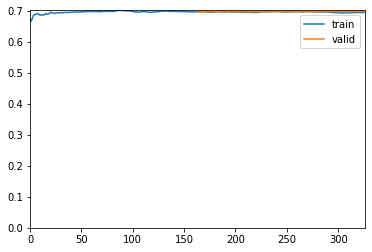

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.691596,0.696326,0.484709,0.474934,0.566038,01:39
1,0.694473,0.697633,0.466361,0.460759,0.572327,01:39
2,0.693810,0.697556,0.474006,0.470588,0.654088,01:39
3,0.691643,0.697427,0.478593,0.474836,0.682390,01:39


Better model found at epoch 0 with valid_loss value: 0.6963263750076294.


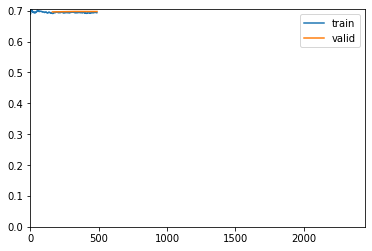

No improvement since epoch 0: early stopping


In [11]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [12]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

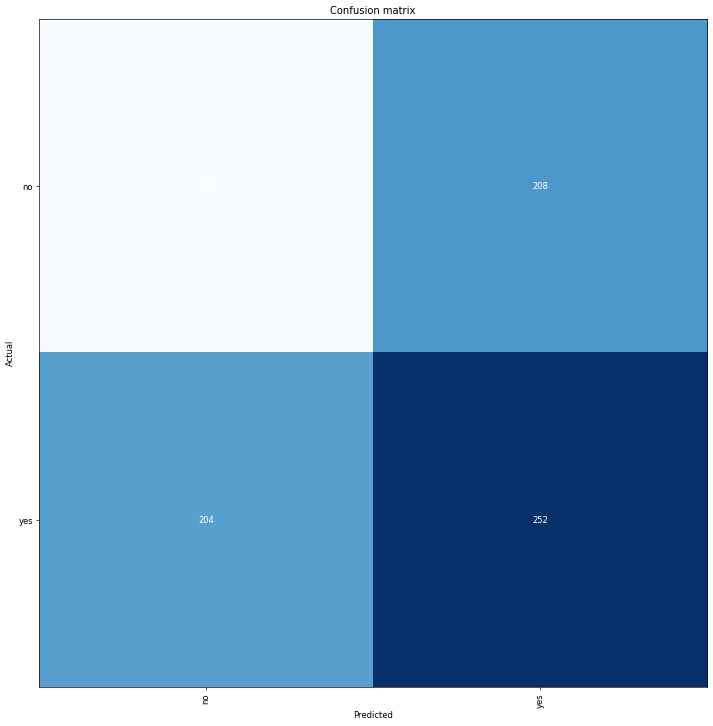

In [13]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [14]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.48946717381477356.


(#4) [0.6967379450798035,0.48946717381477356,0.5478260869565217,0.5526315789473685]

## Faltten

In [15]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.717025,0.694386,0.489297,0.487692,0.996855,01:36
1,0.701311,0.698701,0.486239,0.486239,1.000000,01:36


Better model found at epoch 0 with valid_loss value: 0.694385826587677.


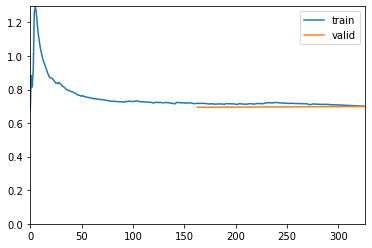

In [16]:
learn.fit_flat_cos(2,lr=1e-3)

In [17]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=0.6309573650360107)

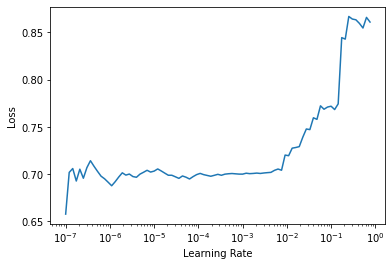

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.694511,0.739973,0.510703,0.375000,0.009434,01:38
1,0.692513,0.690401,0.519878,0.510870,0.295597,01:38
2,0.689942,0.709074,0.530581,0.525346,0.358491,01:38
3,0.676160,0.673275,0.585627,0.582456,0.522013,01:38
4,0.669372,0.693173,0.623853,0.586124,0.770440,01:38
5,0.646615,0.636196,0.662080,0.652997,0.650943,01:37
6,0.632383,0.636987,0.666667,0.637363,0.729560,01:36
7,0.610907,0.622068,0.685015,0.683007,0.657233,01:36
8,0.602625,0.603742,0.657492,0.686508,0.544025,01:36
9,0.584537,0.589254,0.694190,0.706294,0.635220,01:35


Better model found at epoch 0 with valid_loss value: 0.7399730682373047.


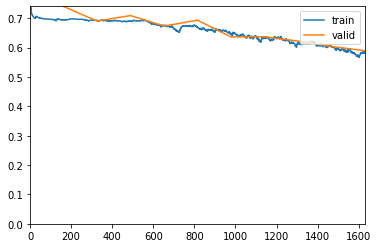

Better model found at epoch 1 with valid_loss value: 0.6904009580612183.
Better model found at epoch 3 with valid_loss value: 0.6732749938964844.
Better model found at epoch 5 with valid_loss value: 0.6361960172653198.
Better model found at epoch 7 with valid_loss value: 0.6220682263374329.
Better model found at epoch 8 with valid_loss value: 0.6037420630455017.
Better model found at epoch 9 with valid_loss value: 0.5892541408538818.


In [19]:
learn.fit_flat_cos(10,lr=1e-4)

In [20]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

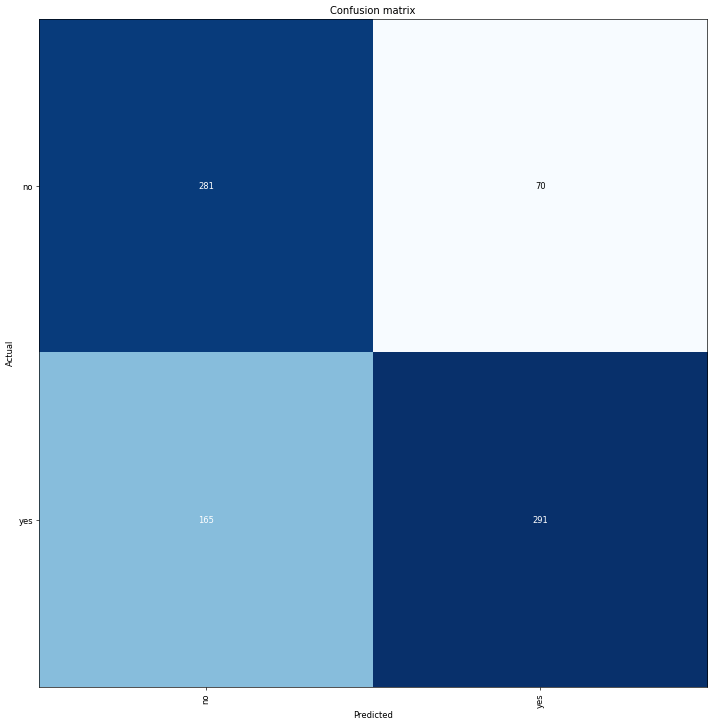

In [21]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [22]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7087979912757874.


(#4) [0.5695003271102905,0.7087979912757874,0.8060941828254847,0.6381578947368421]

## LabelSmoothing

In [23]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=1.5848931980144698e-06)

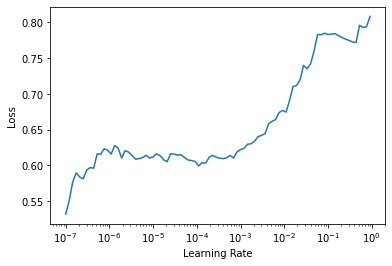

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.596625,0.635135,0.663609,0.722727,0.500000,01:36
1,0.608337,0.624921,0.669725,0.719828,0.525157,01:36


Better model found at epoch 0 with valid_loss value: 0.6351354122161865.


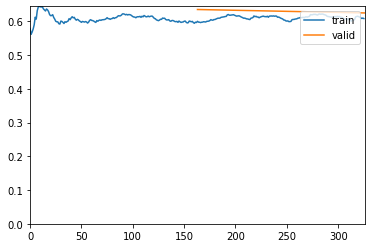

Better model found at epoch 1 with valid_loss value: 0.6249210238456726.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.596410,0.598334,0.685015,0.718750,0.578616,01:36
1,0.604404,0.600342,0.700306,0.750000,0.575472,01:36
2,0.576686,0.593935,0.729358,0.723810,0.716981,01:36
3,0.583525,0.605033,0.711009,0.739777,0.625786,01:36
4,0.584082,0.584749,0.727829,0.731788,0.694969,01:36
5,0.583941,0.591501,0.723242,0.709480,0.729560,01:36
6,0.572030,0.577343,0.733945,0.719512,0.742138,01:36
7,0.570736,0.574334,0.735474,0.723077,0.738994,01:36
8,0.564013,0.569573,0.743119,0.750000,0.707547,01:36
9,0.545522,0.580790,0.729358,0.715596,0.735849,01:36


Better model found at epoch 0 with valid_loss value: 0.5983337163925171.


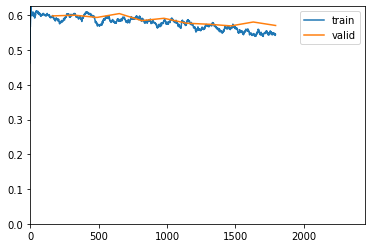

Better model found at epoch 2 with valid_loss value: 0.5939351320266724.
Better model found at epoch 4 with valid_loss value: 0.5847486853599548.
Better model found at epoch 6 with valid_loss value: 0.5773431062698364.
Better model found at epoch 7 with valid_loss value: 0.5743338465690613.
Better model found at epoch 8 with valid_loss value: 0.5695732831954956.
No improvement since epoch 8: early stopping


In [25]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

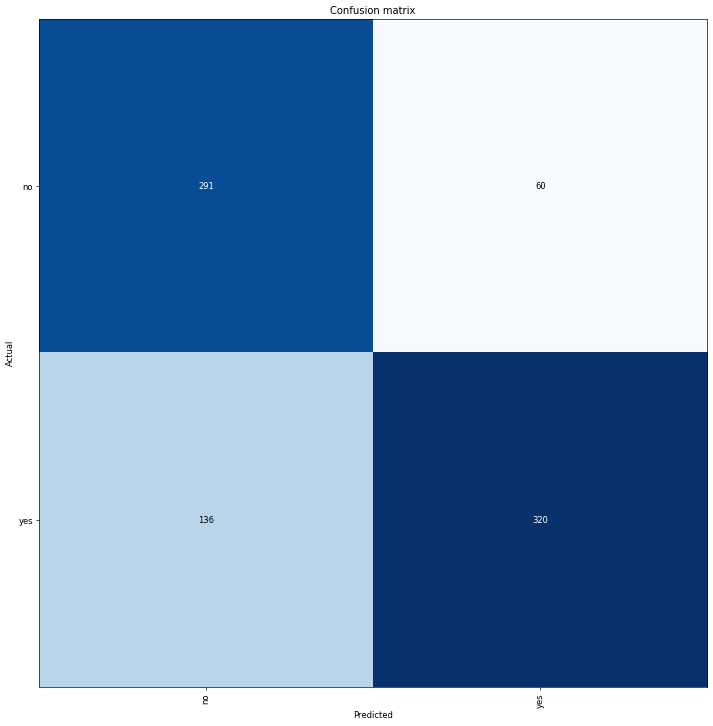

In [27]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [28]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7571251392364502.


(#4) [0.5515421628952026,0.7571251392364502,0.8421052631578947,0.7017543859649122]

## MixUp

In [10]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [30]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.586007,0.559828,0.706422,0.681034,0.745283,01:35
1,0.600352,0.560927,0.723242,0.709480,0.729560,01:36


Better model found at epoch 0 with valid_loss value: 0.5598276853561401.


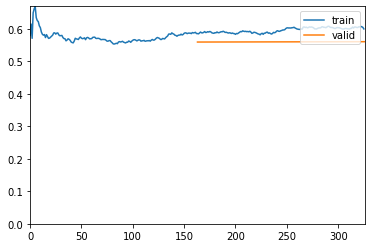

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.581164,0.541443,0.741590,0.770909,0.666667,01:36
1,0.560499,0.543628,0.740061,0.772059,0.660377,01:36
2,0.575460,0.550614,0.726300,0.709970,0.738994,01:36
3,0.589427,0.568141,0.726300,0.758364,0.641509,01:36


Better model found at epoch 0 with valid_loss value: 0.5414427518844604.


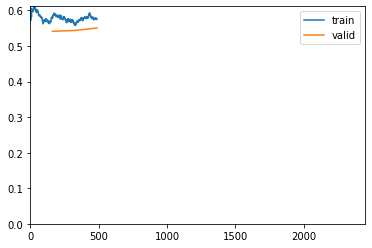

No improvement since epoch 0: early stopping


In [31]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [32]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [33]:
learn.dls = dlsTest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7670384049415588.


(#4) [0.5131204128265381,0.7670384049415588,0.8435897435897436,0.7214912280701754]

## Ranger + Flat cosin Anneal

In [11]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.690912,0.689361,0.539755,0.644068,0.119497,02:10
1,0.680699,0.680569,0.570336,0.561462,0.531447,02:12


Better model found at epoch 0 with valid_loss value: 0.6893611550331116.


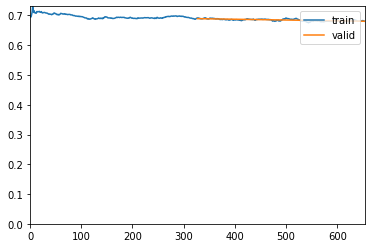

Better model found at epoch 1 with valid_loss value: 0.6805685758590698.


In [12]:
learn.fit_flat_cos(2,lr=1e-3)

In [13]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=1.5848932266235352)

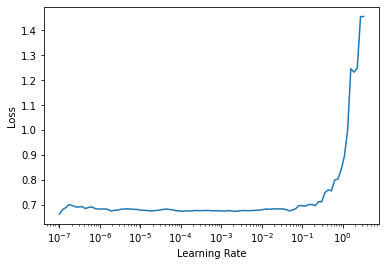

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.676284,0.680606,0.564220,0.552381,0.547170,02:12
1,0.673612,0.679671,0.574924,0.565789,0.540881,02:13
2,0.675488,0.677742,0.565749,0.561151,0.490566,02:12
3,0.665090,0.677340,0.591743,0.574780,0.616352,02:12
4,0.671486,0.679172,0.588685,0.559036,0.729560,02:13
5,0.679493,0.675728,0.568807,0.581081,0.405660,02:13
6,0.661448,0.675343,0.600917,0.576819,0.672956,02:13
7,0.676418,0.673877,0.581040,0.572368,0.547170,02:14
8,0.660482,0.672986,0.588685,0.588448,0.512579,02:14
9,0.677314,0.672627,0.584098,0.575658,0.550314,02:12


Better model found at epoch 0 with valid_loss value: 0.680605947971344.


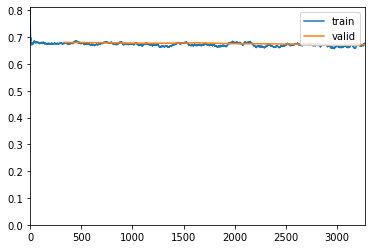

Better model found at epoch 1 with valid_loss value: 0.6796712875366211.
Better model found at epoch 2 with valid_loss value: 0.6777419447898865.
Better model found at epoch 3 with valid_loss value: 0.6773403882980347.
Better model found at epoch 5 with valid_loss value: 0.6757276058197021.
Better model found at epoch 6 with valid_loss value: 0.6753426790237427.
Better model found at epoch 7 with valid_loss value: 0.6738767623901367.
Better model found at epoch 8 with valid_loss value: 0.6729856729507446.
Better model found at epoch 9 with valid_loss value: 0.6726266741752625.


In [15]:
learn.fit_flat_cos(10,lr=1e-4)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6047087907791138.


(#4) [0.6707645058631897,0.6047087907791138,0.6797900262467191,0.5679824561403509]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [19]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.669893,0.672027,0.573394,0.622642,0.311321,02:11
1,0.655175,0.661146,0.636086,0.619048,0.654088,02:12


Better model found at epoch 0 with valid_loss value: 0.6720272898674011.


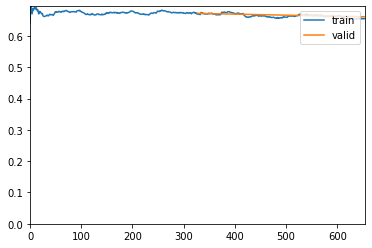

Better model found at epoch 1 with valid_loss value: 0.6611464619636536.


In [20]:
learn.fit_flat_cos(2,lr=1e-3)

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=2.75422871709452e-06)

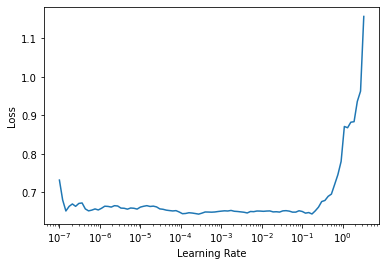

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.657007,0.659194,0.640673,0.623145,0.660377,02:12
1,0.662015,0.658213,0.631498,0.654618,0.512579,02:14
2,0.653391,0.655616,0.634557,0.620061,0.641509,02:12
3,0.651798,0.655275,0.648318,0.658273,0.575472,02:14
4,0.648626,0.653767,0.651376,0.659574,0.584906,02:15
5,0.647752,0.653267,0.636086,0.670940,0.493711,02:16
6,0.645863,0.649326,0.651376,0.670455,0.556604,02:15
7,0.636182,0.648259,0.646789,0.664151,0.553459,02:15
8,0.654750,0.647637,0.654434,0.664286,0.584906,02:18
9,0.632869,0.648756,0.648318,0.657143,0.578616,02:17


Better model found at epoch 0 with valid_loss value: 0.6591939926147461.


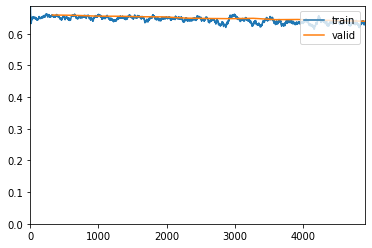

Better model found at epoch 1 with valid_loss value: 0.6582126021385193.
Better model found at epoch 2 with valid_loss value: 0.6556158065795898.
Better model found at epoch 3 with valid_loss value: 0.6552746295928955.
Better model found at epoch 4 with valid_loss value: 0.6537668108940125.
Better model found at epoch 5 with valid_loss value: 0.6532673239707947.
Better model found at epoch 6 with valid_loss value: 0.6493259072303772.
Better model found at epoch 7 with valid_loss value: 0.6482588648796082.
Better model found at epoch 8 with valid_loss value: 0.6476366519927979.
Better model found at epoch 10 with valid_loss value: 0.6445437073707581.
Better model found at epoch 12 with valid_loss value: 0.6428568363189697.
Better model found at epoch 13 with valid_loss value: 0.6411577463150024.
Better model found at epoch 14 with valid_loss value: 0.639522910118103.


In [23]:
learn.fit_flat_cos(15,lr=1e-4)

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [25]:
learn.dls = dlsTest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6666666865348816.


(#4) [0.635949969291687,0.6666666865348816,0.7648725212464589,0.5921052631578947]

## Ranger +Flat + Label + MixUp

In [27]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.664106,0.647072,0.629969,0.711111,0.402516,02:08
1,0.660587,0.634669,0.657492,0.680769,0.556604,02:07


Better model found at epoch 0 with valid_loss value: 0.6470723152160645.


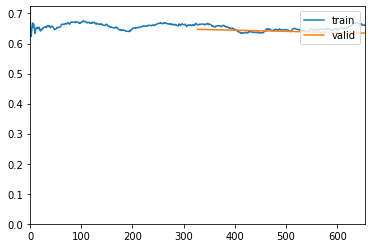

Better model found at epoch 1 with valid_loss value: 0.6346688866615295.


In [28]:
learn.fit_flat_cos(2,lr=1e-3)

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.653145,0.635760,0.659021,0.664360,0.603774,02:07
1,0.635874,0.635250,0.648318,0.648649,0.603774,02:20
2,0.645677,0.635087,0.651376,0.657343,0.591195,02:22
3,0.653754,0.635662,0.649847,0.652921,0.597484,02:25
4,0.642616,0.632620,0.655963,0.674157,0.566038,02:24
5,0.643578,0.631985,0.646789,0.671937,0.534591,02:22
6,0.643294,0.633671,0.654434,0.666667,0.578616,02:14
7,0.627795,0.629306,0.657492,0.660959,0.606918,02:14
8,0.641631,0.629145,0.662080,0.672598,0.594340,02:13
9,0.648628,0.630615,0.654434,0.685484,0.534591,02:14


Better model found at epoch 0 with valid_loss value: 0.6357598900794983.


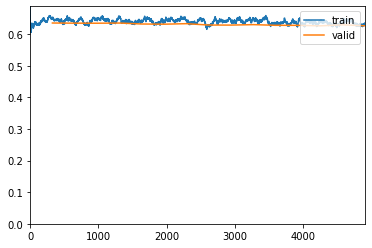

Better model found at epoch 1 with valid_loss value: 0.6352501511573792.
Better model found at epoch 2 with valid_loss value: 0.635087251663208.
Better model found at epoch 4 with valid_loss value: 0.6326199769973755.
Better model found at epoch 5 with valid_loss value: 0.6319847106933594.
Better model found at epoch 7 with valid_loss value: 0.6293064951896667.
Better model found at epoch 8 with valid_loss value: 0.6291452646255493.
Better model found at epoch 10 with valid_loss value: 0.6285011768341064.
Better model found at epoch 11 with valid_loss value: 0.628369152545929.
Better model found at epoch 12 with valid_loss value: 0.626811146736145.


In [30]:
learn.fit_flat_cos(15,lr=1e-4)

In [31]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [32]:
learn.dls = dlsTest

In [33]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.727385401725769.


(#4) [0.6068653464317322,0.727385401725769,0.7906403940886699,0.7039473684210527]

## Ranger + Flat + MixUp

In [34]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [35]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.616555,0.607078,0.672783,0.652047,0.701258,02:12
1,0.628289,0.602837,0.677370,0.777202,0.471698,02:13


Better model found at epoch 0 with valid_loss value: 0.6070778965950012.


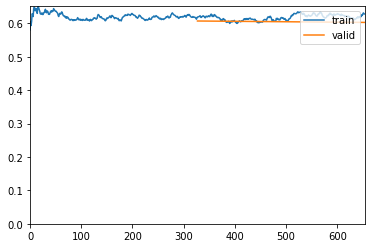

Better model found at epoch 1 with valid_loss value: 0.6028366684913635.


In [36]:
learn.fit_flat_cos(2,lr=1e-3)

In [37]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.601101,0.594852,0.689602,0.755556,0.534591,02:12
1,0.607346,0.596148,0.677370,0.753555,0.500000,02:12
2,0.596874,0.596638,0.678899,0.757143,0.500000,02:12
3,0.620545,0.590395,0.681957,0.750000,0.518868,02:12
4,0.630928,0.596711,0.686544,0.781095,0.493711,02:13
5,0.594247,0.587777,0.672783,0.722222,0.531447,02:13
6,0.604863,0.588938,0.677370,0.737778,0.522013,02:14
7,0.612242,0.586464,0.677370,0.731602,0.531447,02:14
8,0.608887,0.578812,0.692661,0.720755,0.600629,02:13
9,0.599180,0.582097,0.681957,0.706767,0.591195,02:13


Better model found at epoch 0 with valid_loss value: 0.5948517918586731.


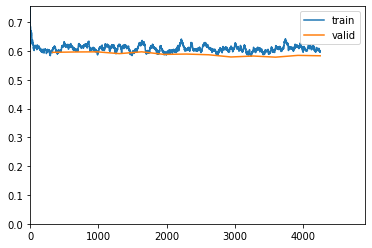

Better model found at epoch 3 with valid_loss value: 0.5903949737548828.
Better model found at epoch 5 with valid_loss value: 0.5877774953842163.
Better model found at epoch 7 with valid_loss value: 0.5864641070365906.
Better model found at epoch 8 with valid_loss value: 0.578811764717102.
Better model found at epoch 10 with valid_loss value: 0.5781551599502563.
No improvement since epoch 10: early stopping


In [38]:
learn.fit_flat_cos(15,lr=1e-4)

In [39]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [40]:
learn.dls = dlsTest

In [41]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7385377883911133.


(#4) [0.5522269606590271,0.7385377883911133,0.886435331230284,0.6162280701754386]

## Ranger + MixUp

In [42]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [43]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.604236,0.584575,0.685015,0.717054,0.581761,02:13
1,0.589250,0.583494,0.680428,0.724280,0.553459,02:13


Better model found at epoch 0 with valid_loss value: 0.5845746994018555.


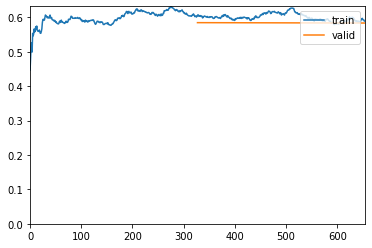

Better model found at epoch 1 with valid_loss value: 0.5834938287734985.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.611912,0.583087,0.685015,0.735294,0.550314,02:12
1,0.615790,0.575998,0.697248,0.715827,0.625786,02:13
2,0.596656,0.577832,0.692661,0.706714,0.628931,02:14
3,0.600375,0.582875,0.686544,0.755656,0.525157,02:13
4,0.590302,0.585681,0.692661,0.777251,0.515723,02:13


Better model found at epoch 0 with valid_loss value: 0.5830870270729065.


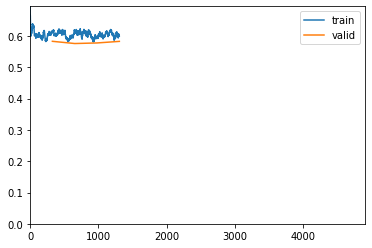

Better model found at epoch 1 with valid_loss value: 0.575997531414032.
No improvement since epoch 1: early stopping


In [44]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [45]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [46]:
learn.dls = dlsTest

In [47]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7546468377113342.


(#4) [0.5429998636245728,0.7546468377113342,0.864406779661017,0.6710526315789473]

## Faltten + MixUp

In [48]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.717307,0.734761,0.490826,0.486085,0.823899,02:08
1,0.706492,0.748345,0.486239,0.486239,1.000000,02:08


Better model found at epoch 0 with valid_loss value: 0.7347612977027893.


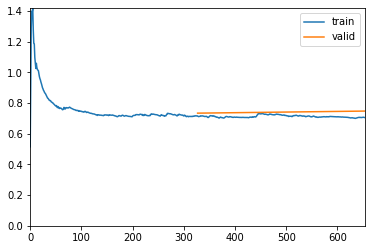

In [49]:
learn.fit_flat_cos(2,lr=1e-3)

In [50]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.695478,0.719656,0.486239,0.485000,0.915094,02:08
1,0.695389,0.694502,0.513761,0.000000,0.000000,02:08
2,0.699605,1.432394,0.512232,0.493671,0.122642,02:08
3,0.699469,0.702788,0.477064,0.475806,0.742138,02:08
4,0.693242,0.722637,0.489297,0.487730,1.000000,02:08


Better model found at epoch 0 with valid_loss value: 0.7196564078330994.


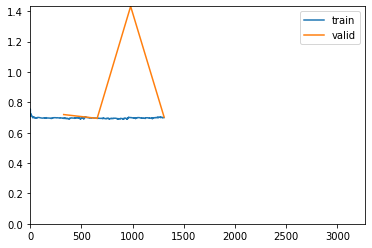

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 0.6945017576217651.
No improvement since epoch 1: early stopping


In [51]:
learn.fit_flat_cos(10,lr=1e-4)

In [52]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [53]:
learn.dls = dlsTest

In [54]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7024838924407959,0.4349442422389984,0.0,0.0]

## Ranger + Label

In [55]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [56]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.697240,0.693440,0.513761,0.000000,0.000000,02:12
1,0.695205,0.694676,0.507645,0.000000,0.000000,02:13


Better model found at epoch 0 with valid_loss value: 0.693440318107605.


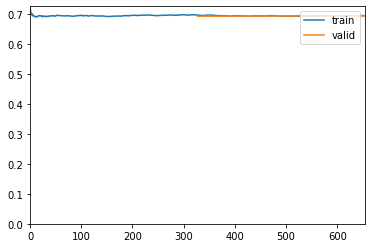

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.695550,0.693229,0.513761,0.000000,0.000000,02:12
1,0.694081,0.693210,0.513761,0.000000,0.000000,02:13
2,0.693373,0.692979,0.515290,1.000000,0.003145,02:12
3,0.693681,0.693217,0.512232,0.333333,0.003145,02:13
4,0.693145,0.695421,0.509174,0.457143,0.050314,02:12
5,0.693714,0.694090,0.512232,0.478261,0.034591,02:13


Better model found at epoch 0 with valid_loss value: 0.6932288408279419.


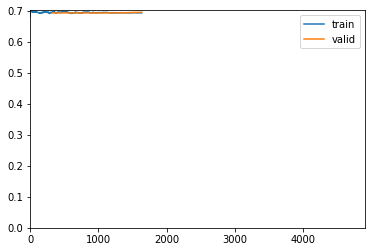

Better model found at epoch 1 with valid_loss value: 0.6932098865509033.
Better model found at epoch 2 with valid_loss value: 0.6929786801338196.
No improvement since epoch 2: early stopping


In [57]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [58]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [59]:
learn.dls = dlsTest

In [60]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4361833930015564.


(#4) [0.6971837282180786,0.4361833930015564,0.6666666666666666,0.0043859649122807015]

## Faltten + Label

In [61]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.715223,2.162499,0.489297,0.486063,0.877358,02:07
1,0.701112,0.744371,0.498471,0.491803,0.943396,02:07


Better model found at epoch 0 with valid_loss value: 2.162498950958252.


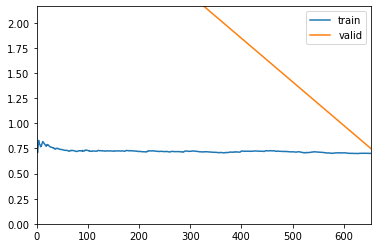

Better model found at epoch 1 with valid_loss value: 0.744370698928833.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=0.3630780577659607)

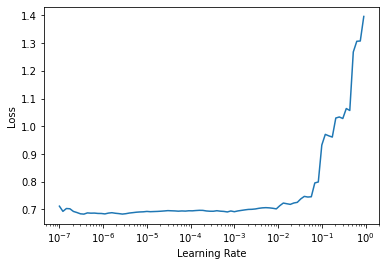

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.695709,0.829983,0.486239,0.486239,1.000000,02:08
1,0.696351,0.697914,0.513761,0.500000,0.003145,02:08
2,0.695936,0.694945,0.489297,0.486667,0.918239,02:08
3,0.695623,0.699588,0.483180,0.484177,0.962264,02:08
4,0.694615,0.693596,0.522936,0.505618,0.849057,02:08
5,0.698400,0.693611,0.515290,0.500907,0.867925,02:08
6,0.697521,0.693535,0.484709,0.483186,0.858491,02:08
7,0.695214,0.701276,0.492355,0.488294,0.918239,02:08
8,0.695258,0.697309,0.489297,0.484962,0.811321,02:08
9,0.691942,0.699196,0.487768,0.484574,0.839623,02:09


Better model found at epoch 0 with valid_loss value: 0.8299834132194519.


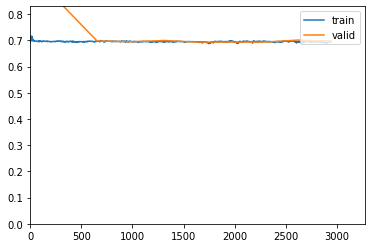

Better model found at epoch 1 with valid_loss value: 0.6979135274887085.
Better model found at epoch 2 with valid_loss value: 0.6949450969696045.
Better model found at epoch 4 with valid_loss value: 0.6935959458351135.
Better model found at epoch 6 with valid_loss value: 0.6935347318649292.
No improvement since epoch 6: early stopping


In [65]:
learn.fit_flat_cos(10,lr=1e-4)

In [66]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [67]:
learn.dls = dlsTest

In [68]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.553903341293335.


(#4) [0.6943250298500061,0.553903341293335,0.5659340659340659,0.9035087719298246]

## Label + MixUp

In [69]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.692799,0.748683,0.513761,0.000000,0.000000,02:08
1,0.694469,0.692624,0.492355,0.487633,0.867925,02:08


Better model found at epoch 0 with valid_loss value: 0.7486826181411743.


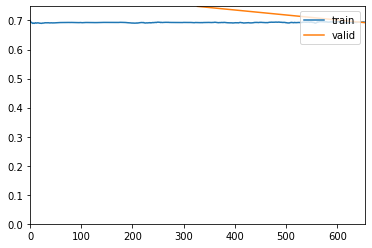

Better model found at epoch 1 with valid_loss value: 0.6926237940788269.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.694498,0.694281,0.487768,0.485062,0.867925,02:08
1,0.694045,0.704799,0.484709,0.482633,0.830189,02:08
2,0.693489,0.697384,0.493884,0.488774,0.889937,02:09
3,0.694484,0.703796,0.490826,0.486631,0.858491,02:08


Better model found at epoch 0 with valid_loss value: 0.6942812204360962.


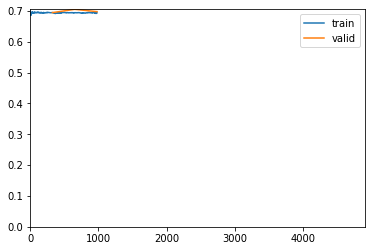

No improvement since epoch 0: early stopping


In [70]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5662949085235596.


(#4) [0.6930213570594788,0.5662949085235596,0.5732044198895028,0.9100877192982456]